In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
def show_gray_images(images, m=8, alpha=3):
    n, h, w = images.shape
    num_rows = (n + m - 1) // m
    fig, axes = plt.subplots(num_rows, m, figsize=(m * 2*alpha, num_rows * 2*alpha))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    for i in range(num_rows):
        for j in range(m):
            idx = i*m + j
            if m == 1 or num_rows == 1:
                axes[idx].imshow(images[idx], cmap='gray')
                axes[idx].axis('off')
            elif idx < n:
                axes[i, j].imshow(images[idx], cmap='gray')
                axes[i, j].axis('off')
    plt.show()
    
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [3]:
from SAM.segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = r"SAM\notebooks\sam_vit_l_0b3195.pth"
model_type = "vit_l"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

d:\miniconda\envs\Trans\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


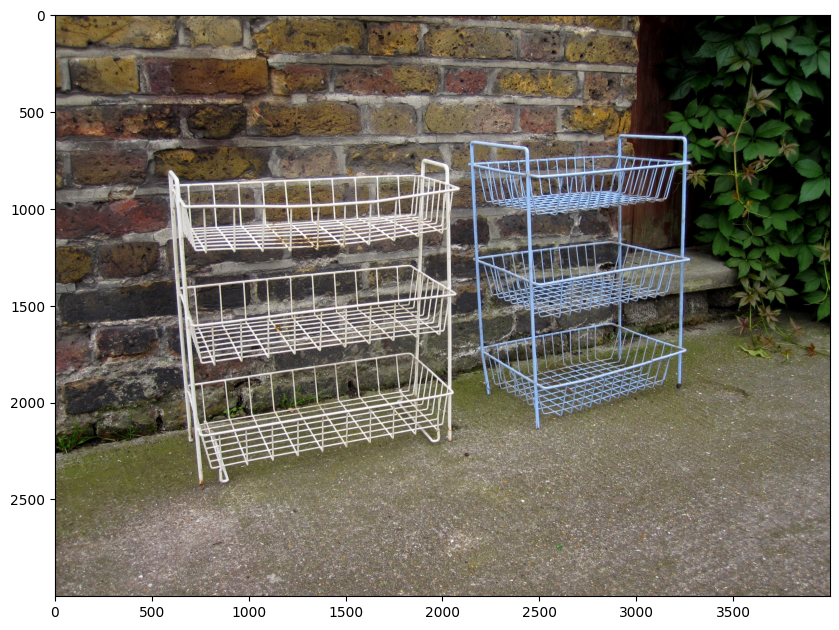

In [4]:
image = cv2.imread('images/test.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor.set_image(image)
plt.figure(figsize=(10,10))
plt.axis('on')
plt.imshow(image)
plt.show()  

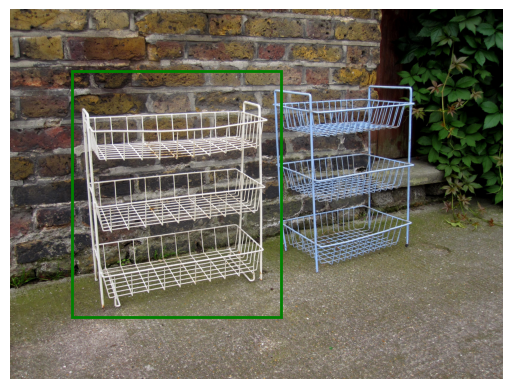

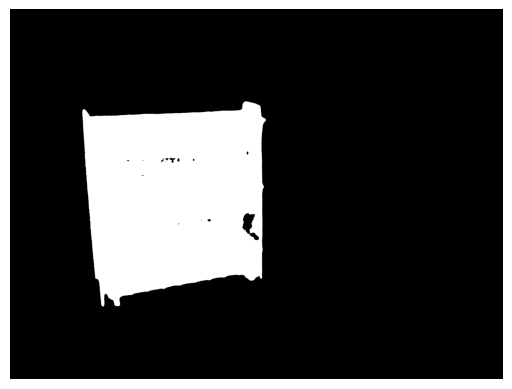

In [5]:
input_label = np.array([1])

input_box = np.array([500,500,2200,2500])

masks, scores, logits = predictor.predict(
    box=input_box,
    point_labels=input_label,
    multimask_output=True,
)
mask = masks[0]
# plt.figure(figsize=(20,20))
show_box(input_box, plt.gca())
plt.axis('off')
plt.xticks([])
plt.imshow(image)
plt.show()  
plt.axis('off')
plt.xticks([])
plt.imshow(mask,cmap='gray')
plt.show()  

In [6]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F
import gdown
import os
import cv2

import requests
import matplotlib.pyplot as plt
from io import BytesIO
from IS_Net.data_loader import normalize, im_reader, im_preprocess
from IS_Net.models.isnet import ISNetGTEncoder, ISNetDIS

class GOSNormalize(object):
    '''
    Normalize the Image using torch.transforms
    '''
    def __init__(self, mean=[0.485,0.456,0.406,0], std=[0.229,0.224,0.225,1.0]):
        self.mean = mean
        self.std = std

    def __call__(self,image):
        image = normalize(image,self.mean,self.std)
        return image

transform =  transforms.Compose([GOSNormalize([0.5,0.5,0.5,0,0],[1.0,1.0,1.0,1.0,1.0])])

def build_model(hypar,device):
    net = hypar["model"]#GOSNETINC(3,1)

    # convert to half precision
    if(hypar["model_digit"]=="half"):
        net.half()
        for layer in net.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.float()

    net.to(device)

    if(hypar["restore_model"]!=""):
        net.load_state_dict(torch.load(hypar["model_path"]+"/"+hypar["restore_model"],map_location=device))
        net.to(device)
    net.eval()  
    return net

def get_box(input_box,size):

    # 初始化一个全零的图像
    image = torch.zeros(size)

    # 填充方框区域为白色（值为255）
    image[input_box[1]:input_box[3],input_box[0]:input_box[2]] = 255
    return image

def get_box_from_mask(gt):
    gt = torch.from_numpy(np.array(gt))
    box = torch.zeros_like(gt)+gt
    box = box.float()
    rows, cols = torch.where(box>0)
    left = torch.min(cols)
    top = torch.min(rows)
    right = torch.max(cols)
    bottom = torch.max(rows)
    box[top:bottom,left:right] = 255
    box[box!=255] = 0
    return box

def predict_one(net, image, mask, box, transforms, hypar, device):
    '''
    Given an Image, predict the mask
    '''
    with torch.no_grad():
        image = torch.from_numpy(np.array(image))
        mask = torch.from_numpy(np.array(mask))
        box = torch.from_numpy(np.array(box))
        if mask.max()==1:
            mask = mask.astype(torch.float32)*255.0
        # for i in [image,mask[...,None],box[...,None]]:
            # print(i.shape)
        inputs_val_v = torch.cat([image,mask[...,None],box[...,None]],dim=2)
        inputs_val_v = inputs_val_v.permute(2,0,1)[None,...]
        shapes_val = inputs_val_v.shape[-2:]

        inputs_val_v = F.upsample(inputs_val_v,(hypar["input_size"]),mode='bilinear')
        box = inputs_val_v[0][-1]
        box[box>127] = 255
        box[box<=127] = 0
        inputs_val_v[0][-1] = box
        # plt.imshow(inputs_val_v[0][-1])
        # plt.show()
        inputs_val_v = inputs_val_v.divide(255.0)
        # print(shapes_val)
        net.eval()

        if(hypar["model_digit"]=="full"):
            inputs_val_v = inputs_val_v.type(torch.FloatTensor)
        else:
            inputs_val_v = inputs_val_v.type(torch.HalfTensor)

        
        inputs_val_v = Variable(inputs_val_v, requires_grad=False).to(device) # wrap inputs in Variable
        inputs_val_v = transforms(inputs_val_v)
        # print(inputs_val_v.shape)
        ds_val = net(inputs_val_v)[0][0]
        # print(ds_val.shape)
        ## recover the prediction spatial size to the orignal image size
        pred_val = F.upsample(ds_val,(shapes_val),mode='bilinear')[0][0]
        # print(pred_val.shape)
        ma = torch.max(pred_val)
        mi = torch.min(pred_val)
        pred_val = (pred_val-mi)/(ma-mi) # max = 1

        if device == 'cuda': torch.cuda.empty_cache()
        refined_mask = (pred_val.detach().cpu().numpy()*255).astype(np.uint8)
        # refined_mask[refined_mask>127] = 255
        # refined_mask[refined_mask<=127] = 0
        # refined_mask = 1 - refined_mask.astype(np.byte)
        ret, binary = cv2.threshold(refined_mask, 0, 255, cv2.THRESH_OTSU)
        return  binary# it is the mask we need


In [7]:
hypar = {} # paramters for inferencing

hypar["model_path"] ="saved_models" ## load trained weights from this path
hypar["restore_model"] = "gpu_itr_24000_traLoss_4.7147_traTarLoss_0.2502_valLoss_20.4341_valTarLoss_2.6757_maxF1_0.9251_mae_0.031_time_0.015787.pth" ## name of the to-be-loaded weights

##  choose floating point accuracy --
hypar["model_digit"] = "full" ## indicates "half" or "full" accuracy of float number

## data augmentation parameters ---
hypar["input_size"] = [1024, 1024] ## mdoel input spatial size, usually use the same value hypar["cache_size"], which means we don't further resize the images

hypar["model"] = ISNetDIS(in_ch=5)

net = build_model(hypar, device)

In [8]:
DIS_mask = mask
# DIS_box = get_box(input_box,image.shape[:2])
DIS_box = get_box_from_mask(DIS_mask)
refined_mask = predict_one(net,image,DIS_mask,DIS_box,transform,hypar,device)

AttributeError: 'Tensor' object has no attribute 'astype'

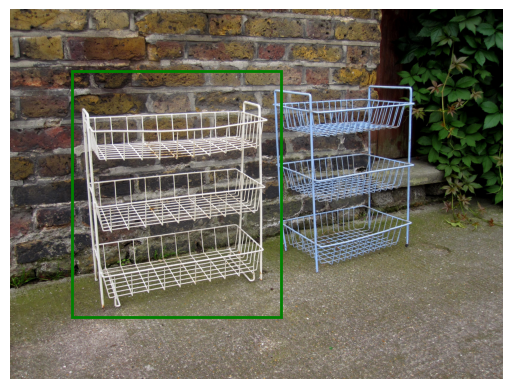

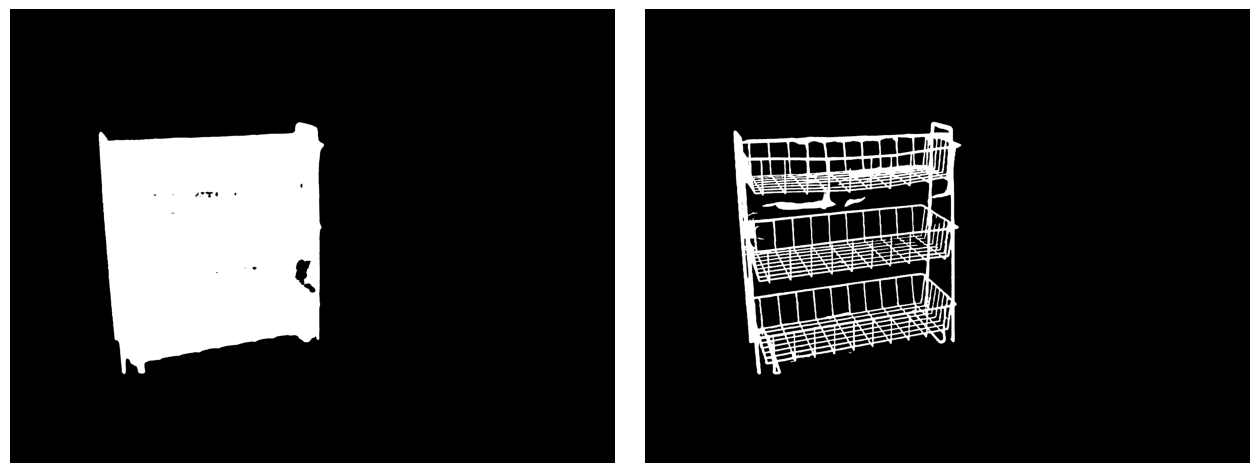

In [ ]:
show_box(input_box, plt.gca())
plt.axis('off')
plt.xticks([])
plt.imshow(image)
plt.show()  
mask_serises = np.concatenate([DIS_mask[None,...],refined_mask[None,...]],axis=0)
show_gray_images(mask_serises,m=2,alpha=4)
# mask_serises.shape